In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pdb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import random
%matplotlib inline

from scipy.stats import norm


class NormalDistributionCollection(object):
    def __init__(self, resolution, var=0.07):
        self.gaussians = torch.stack([self.normal_distribution(resolution, index.item() / resolution, var) for index in np.arange(resolution)])

    @staticmethod
    def normal_distribution(n, mean, var=0.05):
      x = norm.pdf(np.arange(0, 1, 1.0 / n), mean, var)
      x = x / np.max(x)
      return torch.tensor(x).float()

class Confidence(object):
    def __init__(self, resolution):
        self.full_confidence_gaussians = NormalDistributionCollection(resolution, 0.07).gaussians

    def confidence(self, s, resolution):    
        assert resolution == s.shape[1], "Shape must be (t_samples, resolution), found shape {}, resolution specified {}".format(s.shape, resolution)

        #print('s')
        #plot_distribution(s[17].numpy())

        s = normalize_pattern(s, resolution)
        #print('s normalized')
        #plot_distribution(s[17].numpy())

        (maxval, indices) = s.max(dim=1)
        #print(len(indices))
        #print(indices[10])

        gaussians = torch.stack([self.full_confidence_gaussians[indices[index]] for index in np.arange(len(indices))])
        #print('gaussian')
        #plot_distribution(gaussians[17].numpy())

        gaussians = normalize_pattern(gaussians, resolution)

        #print('gaussian normalized')
        #plot_distribution(gaussians[17].numpy())

        #print('gaussian - s')
        #plot_distribution((gaussians - s).numpy())

        #print('gaussians.shape = ', gaussians.shape)
        #print('s.shape =', s.shape)
        diff = (gaussians - s).abs().sum(dim=1) / resolution
        #print('diff = ', diff)
        cutoff = 0.4
        discard_mask = diff > cutoff
        use_mask = diff <= cutoff

        diff[use_mask] = diff[use_mask] / cutoff
        diff[discard_mask] = 1.0

        conf = 1.0 - diff
        #print('conf1 = ', conf)

        return conf


    def confidence_weighted(self, s, resolution):
        #print("s.shape = ", s.shape)
        #print("confidence(s, resolution).shape = ", confidence(s, resolution).shape)
        c = self.confidence(s, resolution)
        c[c > 1] = 1
        sc = (s.t() * c).t()
        return sc

    def normalized(self, sc):
        sc = sc / sc.max(dim=0)[0]
        return sc

    def confidence_weighted_addition(self, a, b, resolution):
        ac = self.confidence(a, resolution)
        bc = self.confidence(b, resolution)

        sum = self.confidence_weighted(a, resolution) + self.confidence_weighted(b, resolution)
        return (sum.t() / (ac + bc)).t()

    def confidence_weighted_subtraction(self, a, b, resolution):
        return self.confidence_weighted(a, resolution) - self.confidence_weighted(b, resolution)

def create_pattern(pattern_length=200, resolution=None, var=0.05, gaussians=None):
    assert resolution is not None
    assert resolution > 0

    if gaussians is None:
        gaussians = NormalDistributionCollection(resolution, 0.07).gaussians

    assert gaussians.shape[0] == resolution
    assert gaussians.shape[1] == resolution

    pattern_floats = torch.tensor((np.sin(np.arange(pattern_length) * 0.30) * np.cos(np.arange(pattern_length) * 0.15) + 1.2 + np.random.sample(int(pattern_length)) * 0) / 2.5).float()
    pattern = torch.stack([gaussians[int(val*resolution)] for val in pattern_floats])
    pattern = pattern / pattern.max().item() # normailze to probability distribution, i.e. sum = 1.0
    # pattern[int(pattern_length*0.4):int(pattern_length*0.6), :] = 0
    imshow('pattern', pattern.t(), confidence=confidence_utility.confidence(pattern, resolution))

    return pattern

def imshow(title, image, vmin=None, vmax=None, confidence=None):
  plt.figure(figsize=figsize)
  t = "{2} [{0}, {1}]".format(image.min(), image.max(), title)
  plt.title(t)
  plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
  plt.show()

  if confidence is not None:
    plt.figure(figsize=figsize)
    plt.title("{2} [{0}, {1}]".format(confidence.min(), confidence.max(), 'confidence'))
    plt.imshow([confidence.numpy()], cmap='gray', vmin=0)
    plt.show()

def plot_distribution(d):
    plt.figure()
    plt.plot(d)
    plt.show()


# def confidence2(s, resolution):    
#     assert resolution == s.shape[1], "Shape must be (t_samples, resolution), found shape {}, resolution specified {}".format(s.shape, resolution)
#     return torch.tensor([confidence_vector(s[i], resolution) for i in np.arange(s.shape[0])])
    
# def confidence_vector(s, resolution):
#     assert len(s.shape) == 1, "Expected 1D vector, got shape {}".format(s.shape)
#     assert resolution == s.shape[0], "Vector length must be {}, got {}".format(resolution, s.shape[0])

#     s = (s - s.min())
#     sm = s.max()
#     if sm > 0:
#         s = s / sm
#     #print('s')
#     #plot_distribution(s.numpy())
#     (maxval, index) = s.max(0)

#     gaussian = normal_distribution(resolution, index.double() / resolution, 0.07)

#     gaussian = (gaussian - gaussian.min())
#     gm = gaussian.max()
#     if gm > 0:
#         gaussian = gaussian / gm

#     #print('gaussian')
#     #plot_distribution(gaussian.numpy())

#     #print('gaussian - s')
#     #plot_distribution((gaussian - s).numpy())

#     diff = (gaussian - s).abs().sum().item() / resolution
#     #print('diff = ', diff)
#     cutoff = 0.4
#     if diff > cutoff:
#         diff = 1.0
#     else:
#         diff = diff / cutoff
#     #print('diff2 = ', diff)

#     conf = 1.0 - diff
#     #print('conf1 = ', conf)
    
#     return conf


#     #print("(s - s.min(dim=0)[0]) ", (s - s.min(dim=0)[0]).shape)
#     #print("((s - s.min(dim=0)[0]).sum(dim=1)) ", ((s - s.min(dim=0)[0]).sum(dim=1)).shape)
#     #print("cum_diff(s) ", cum_diff(s).shape)
#     return ((s - s.min(dim=0)[0]).sum(dim=1)) / (cum_diff(s) * resolution * 0.06)

def normalize_pattern(s, resolution):
    assert resolution == s.shape[1], "Shape must be (t_samples, resolution), found shape {}, resolution specified {}".format(s.shape, resolution)
    #print('s.shape = ', s.shape)
    #print('s.min(dim=1)[0] = ', s.min(dim=1)[0].shape)
    s = s.t()
    s = (s - s.min(dim=0)[0])
    sm = s.max(dim=0)[0]
    #s[sm > 0, :] = s[sm > 0, :] / sm[sm > 0]
    s = s / sm
    s = s.t()
    return s

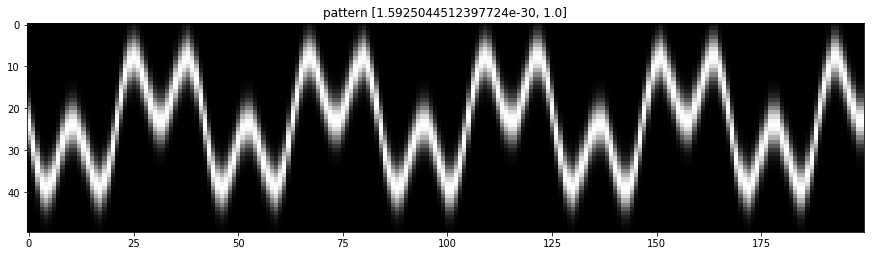

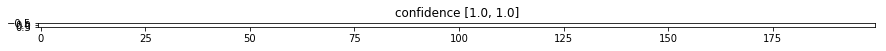

In [2]:
figsize=(15,5)
resolution = 50
confidence_utility = Confidence(resolution)
pattern = create_pattern(var=0.07, resolution=resolution, gaussians=confidence_utility.full_confidence_gaussians)

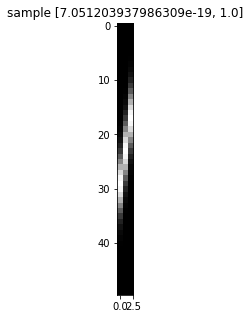

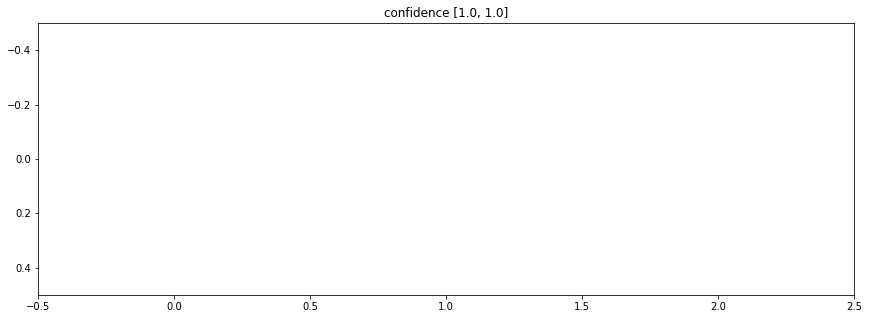

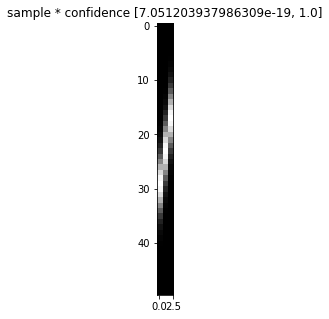

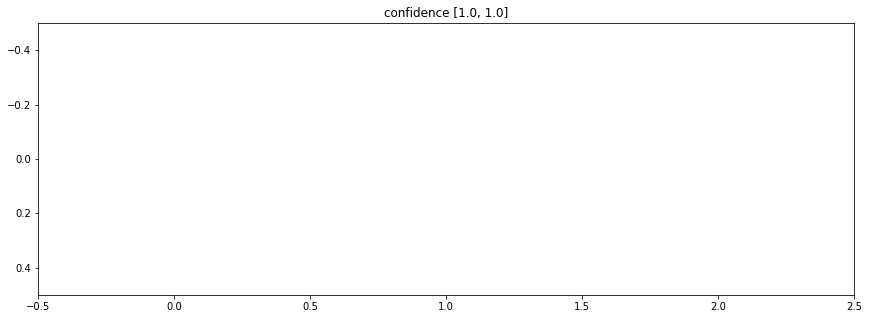

In [3]:
(pattern_length, resolution) = pattern.shape
t_sample = 3
batch_size = pattern_length - t_sample - 1
input = torch.stack([pattern[i:i+t_sample] for i in np.arange(batch_size)])
imshow('sample', input[20].t(), confidence=confidence_utility.confidence(input[20], resolution), vmin=0, vmax=1)

sc = confidence_utility.confidence_weighted(input[20], resolution)
imshow('sample * confidence', sc.t(), confidence=confidence_utility.confidence(sc, resolution), vmin=0, vmax=1)

In [4]:
# # attempt to make encoder self-supervised
# # doesn't work too well
# class Encoder(torch.nn.Module): 
  
#     def __init__(self, n_sample, resolution):
#         super().__init__() 
#         self.linear = torch.nn.Linear(n_sample * resolution, resolution)
  
#     def forward(self, x): 
#         x = self.linear(x)
#         x = F.relu(x)
#         return x

# (batch_size, n_sample, resolution) = input.shape
# encoder = Encoder(n_sample=n_sample, resolution=resolution)
# input_flat = input.view(batch_size, n_sample * resolution)
# optimizer = torch.optim.SGD(encoder.parameters(), lr = 0.01) 

# for epoch in range(2001): 
#     # Forward pass: Compute predicted y by passing  
#     # x to the model 
#     output = encoder(input_flat)
#     maxval, index = output.max(dim=1)
#     # create a gaussian at maxval index as target
#     target = torch.stack([normal_distribution(resolution, index[t].item() * 1.0 / resolution) for t in np.arange(batch_size)])

#     # Compute and print loss 
#     loss = F.mse_loss(output, target)
  
#     # Zero gradients, perform a backward pass,  
#     # and update the weights. 
#     optimizer.zero_grad() 
#     loss.backward() 
#     optimizer.step() 
#     if (epoch-1) % 500 == 0:
#         imshow('output', output.detach().t())
#         imshow('target', target.t())
#         print('epoch {}, loss {}'.format(epoch, loss.data[0])) 

In [24]:
# make encoder-decoder autoencoding
class Encoder(torch.nn.Module): 
  
    def __init__(self, t_sample, resolution, hidden_size):
        super().__init__() 
        self.linear = torch.nn.Linear(t_sample * resolution, hidden_size)
        #self.linear2 = torch.nn.Linear(hidden_size*3, hidden_size*2)
        #self.linear3 = torch.nn.Linear(hidden_size*2, hidden_size)

  
    def forward(self, x): 
        x = self.linear(x)
        #x = F.tanh(x)
        #x = self.linear2(x)
        #x = F.tanh(x)
        #x = self.linear3(x)
        x = F.tanh(x)
        x = (x + 1.0) / 2.0
        v = torch.stack([NormalDistributionCollection.normal_distribution(resolution, val) for val in x])
        v[:, (x/resolution).long()] = x
        return v

class Decoder(torch.nn.Module): 
  
    def __init__(self, hidden_size, resolution):
        super().__init__() 
        self.linear = torch.nn.Linear(hidden_size * resolution, resolution)
        #self.linear2 = torch.nn.Linear(resolution*3, resolution*2)
        #self.linear3 = torch.nn.Linear(resolution*2, resolution)

  
    def forward(self, x): 
        x = self.linear(x)
        #x = F.tanh(x)
        #x = self.linear2(x)
        #x = F.tanh(x)
        #x = self.linear3(x)
        x = F.tanh(x)

        return x

class Network(torch.nn.Module):
    
    def __init__(self, t_sample, resolution, hidden_size):
        super().__init__()
        self.encoder = Encoder(t_sample, resolution, hidden_size)
        self.decoder = Decoder(hidden_size, resolution)
        self.hidden_state = None
        
    def forward(self, x):
        x = self.hidden_state = self.encoder(x)
        x = self.decoder(x)
        return x


def experiment(pattern, t_sample, network=None, epochs=1001, hidden_size=1):
    (pattern_length, resolution) = pattern.shape
    gaussians = confidence_utility.full_confidence_gaussians

    if network is None:
        network = Network(t_sample=t_sample-1, hidden_size=hidden_size, resolution=resolution)

    combined_pattern = pattern

    optimizer = torch.optim.SGD(network.parameters(), lr = 1) 
    #optimizer = torch.optim.Adam(network.parameters(), lr = 0.02) 

    #imshow('target', target_flat.detach().t())
    losses = []
    pred_error_max = []

    for epoch in range(epochs):
        (pattern_length, resolution) = combined_pattern.shape
        batch_size = pattern_length - t_sample - 1
        combined_input = torch.stack([combined_pattern[i:i+t_sample] for i in np.arange(batch_size)])
        input_flat = combined_input[:, :-1, :].detach().view(batch_size, (t_sample - 1) * resolution)
        target_flat = input[:, -1, :].detach().view(batch_size, 1 * resolution)
        #print("pattern.shape = ", combined_pattern.shape)
        #print("combined_input.shape = ", combined_input.shape)
        #print("input_flat.shape = ", input_flat.shape)
        #print("target_flat.shape = ", target_flat.shape)

        # Forward pass
        output = network(input_flat)
        maxval, index = output.max(dim=1)
        #print("output.shape = ", output.shape)

        # Compute and print loss 
        loss = F.mse_loss(output, target_flat)

        # Zero gradients, perform a backward pass,  
        # and update the weights. 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        losses.append(loss.item())

        combined_pattern = pattern.clone()
        combined_pattern[t_sample-1:-2] = confidence_utility.confidence_weighted_addition(pattern[t_sample-1:-2].detach(), output.detach(), resolution)

        pred_error = confidence_utility.confidence_weighted_subtraction(target_flat, output.detach(), resolution)
        pred_error_max.append(pred_error.abs().mean().item())

        if (epoch-1) % int(epochs/3) == 0:
            print('epoch {}, loss {}'.format(epoch, loss.data[0]))
            print('combined_pattern.shape = ', combined_pattern.shape)
            imshow('combined pattern', combined_pattern.t(), confidence=confidence_utility.confidence(combined_pattern, resolution), vmin=0, vmax=1)

            hidden_state = network.hidden_state.detach()
            imshow('hidden state', hidden_state.t(), vmin=0, vmax=1)

            print('output.shape = ', output.shape)
            output_confidence = confidence_utility.confidence(output.detach(), resolution)
            imshow('output', output.detach().t(), confidence=output_confidence, vmin=0, vmax=1)
            imshow('confidence weighted output', confidence_utility.confidence_weighted(output.detach(), resolution).t(), vmin=0, vmax=1)

            imshow('prediction error', pred_error.t(), confidence=confidence_utility.confidence(pred_error, resolution))

            print('hidden_state.shape = ', hidden_state.shape)
            imshow('mu2', hidden_state.t(), confidence=confidence_utility.confidence(hidden_state, resolution), vmin=0, vmax=1)
#             for mu2_value in hidden_state.t():
#                 mu2_confidence = output_confidence
#                 # confidence=1 ==> var=0.07
#                 # confidence=0 ==> var=larger value less than 1.0
#                 mu2_var = (1.35 - mu2_confidence) / 5.0
#                 #print('mu2_value[0] = ', mu2_value[0])
#                 #print('mu2_var[0] = ', mu2_var[0])
#                 #print(NormalDistributionCollection.normal_distribution(resolution, mu2_value[0], mu2_var[0]))
#                 mu2 = [NormalDistributionCollection.normal_distribution(resolution, mu2_value[index], mu2_var[index]) for index in np.arange(mu2_value.shape[0])]

#                 mu2 = torch.stack(mu2)
#                 #print('mu2.shape = ', mu2.shape)
#                 mu2 = mu2 * pred_error.abs().max().item()
#                 #print('mu2.shape = ', mu2.shape)

#                 imshow('mu2', mu2.t(), confidence=confidence_utility.confidence(mu2, resolution), vmin=0, vmax=1)

    plt.figure(figsize=figsize)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

    plt.figure(figsize=figsize)
    plt.title('max abs prediction error')
    plt.plot(pred_error_max)
    plt.show()
    
    return network

/Users/amolk/work/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch 1, loss 0.13527309894561768
combined_pattern.shape =  torch.Size([200, 50])


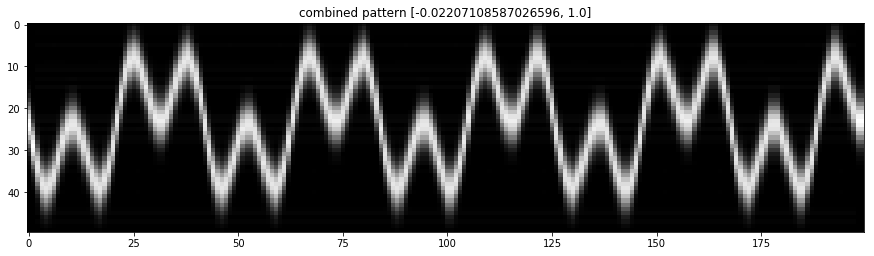

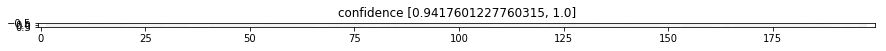

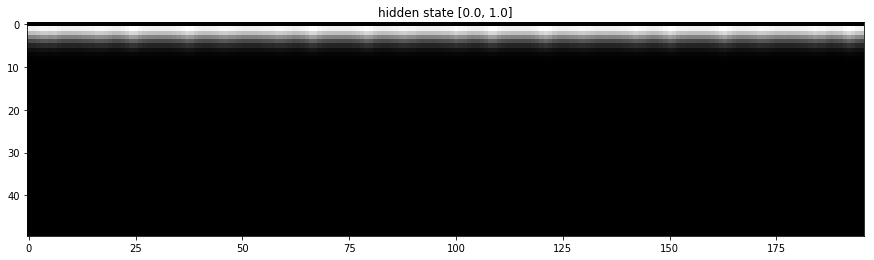

output.shape =  torch.Size([196, 50])


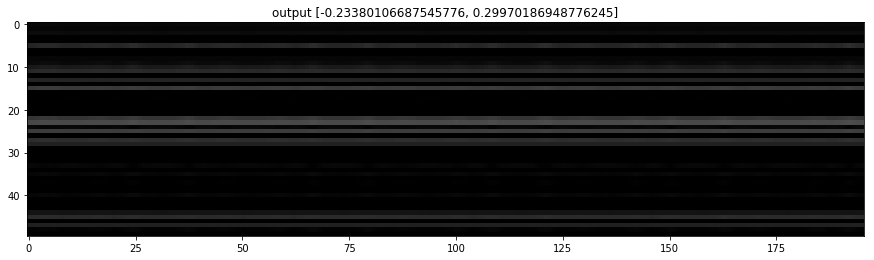

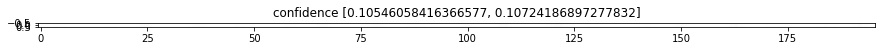

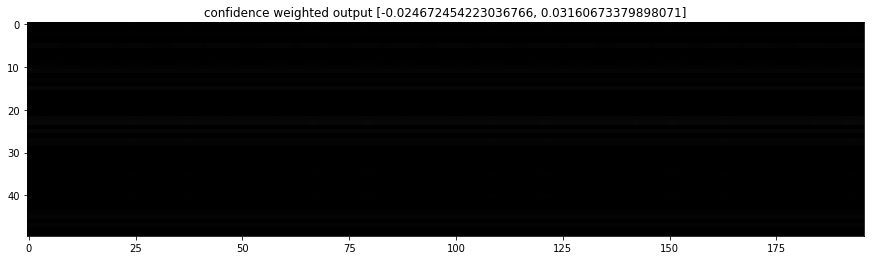

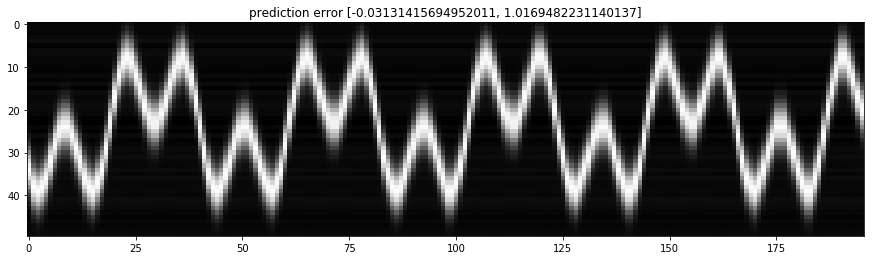

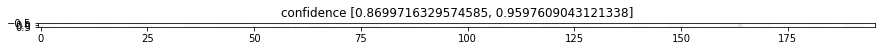

hidden_state.shape =  torch.Size([196, 50])


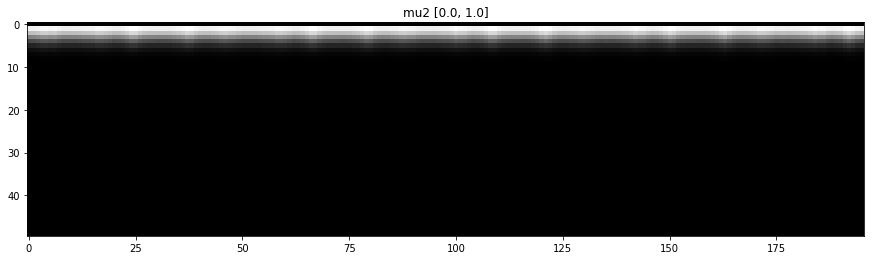

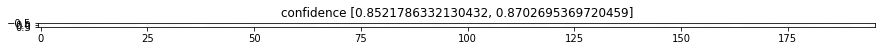

epoch 168, loss 0.08459319174289703
combined_pattern.shape =  torch.Size([200, 50])


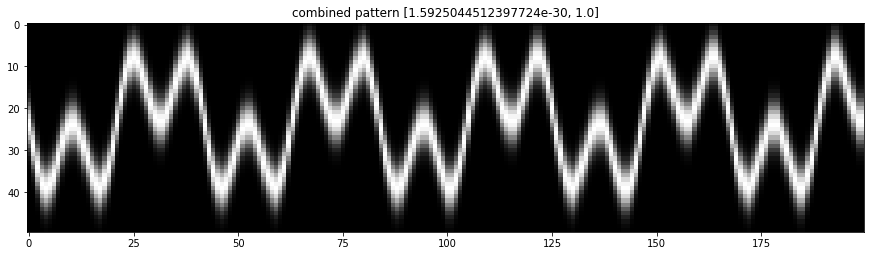

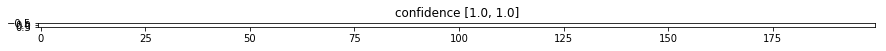

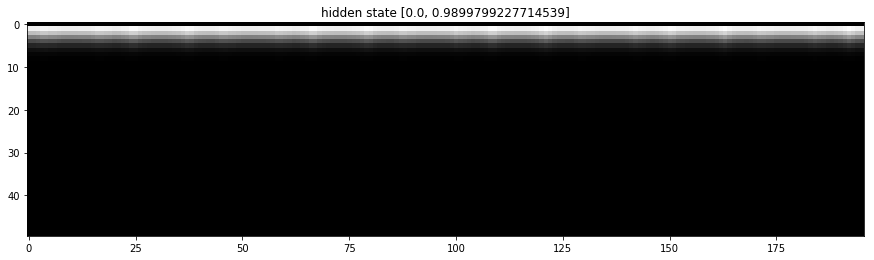

output.shape =  torch.Size([196, 50])


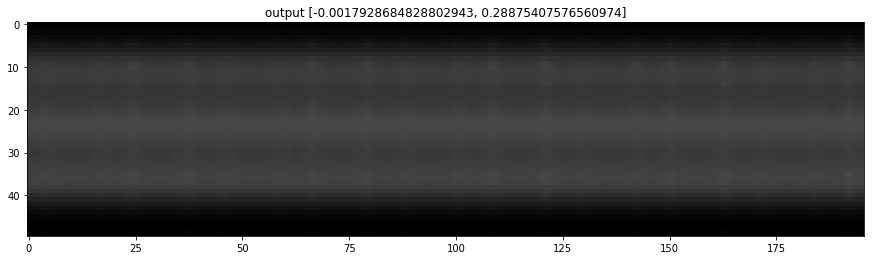

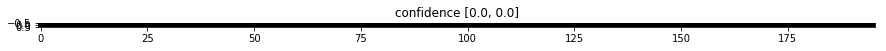

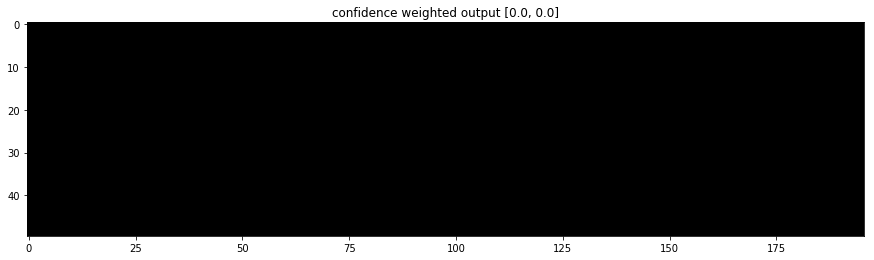

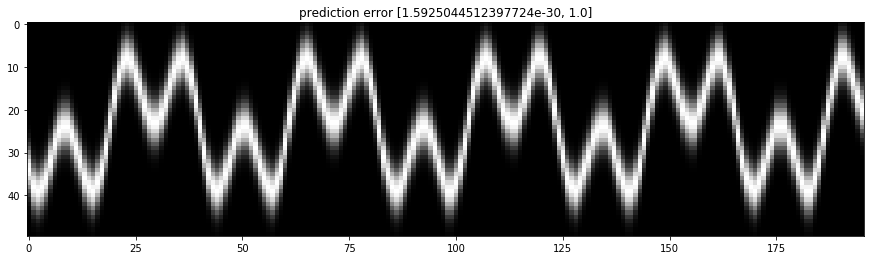

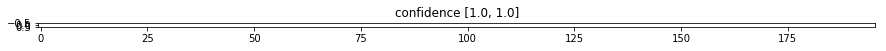

hidden_state.shape =  torch.Size([196, 50])


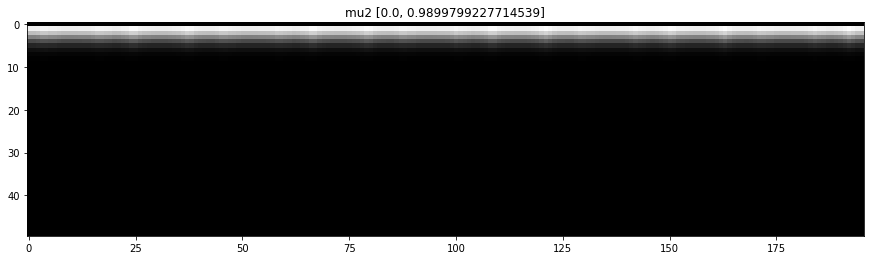

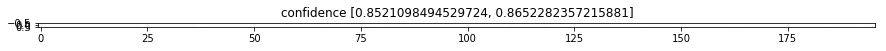

epoch 335, loss 0.08444877713918686
combined_pattern.shape =  torch.Size([200, 50])


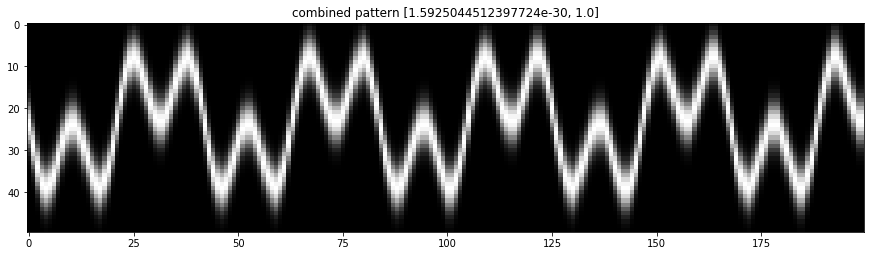

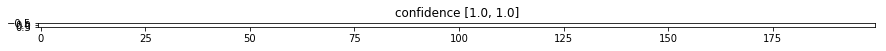

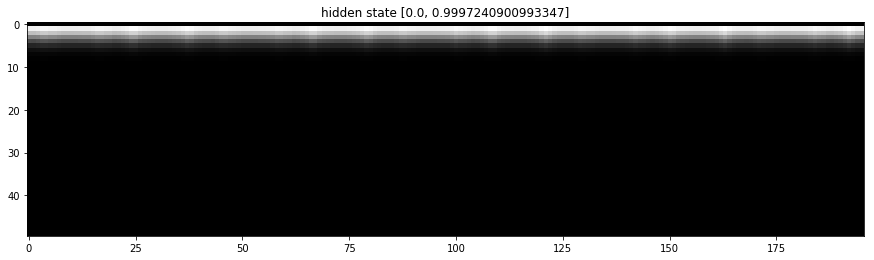

output.shape =  torch.Size([196, 50])


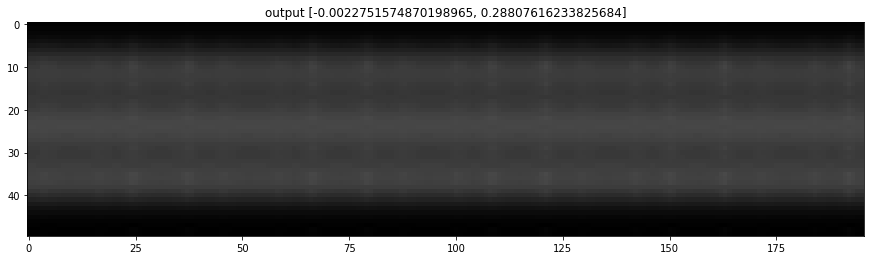

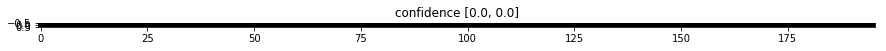

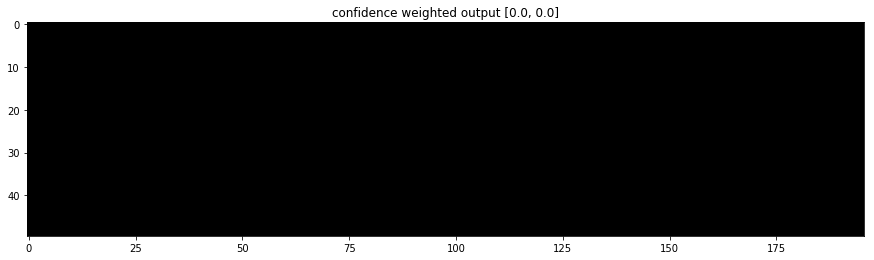

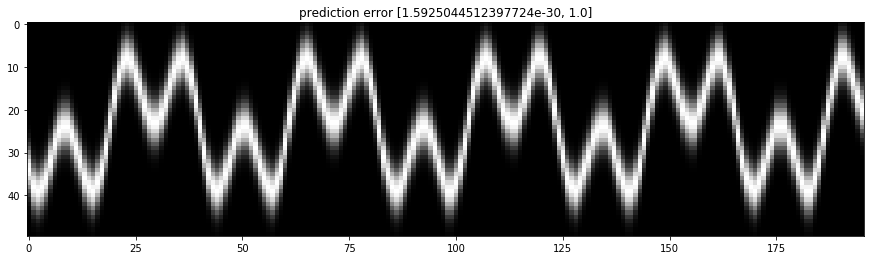

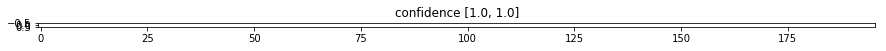

hidden_state.shape =  torch.Size([196, 50])


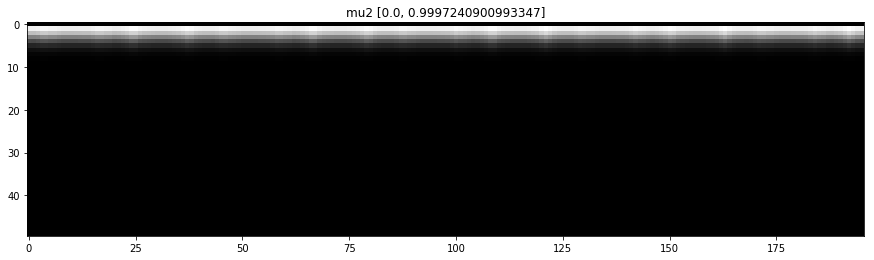

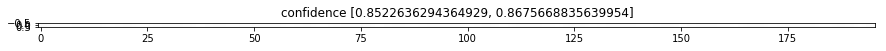

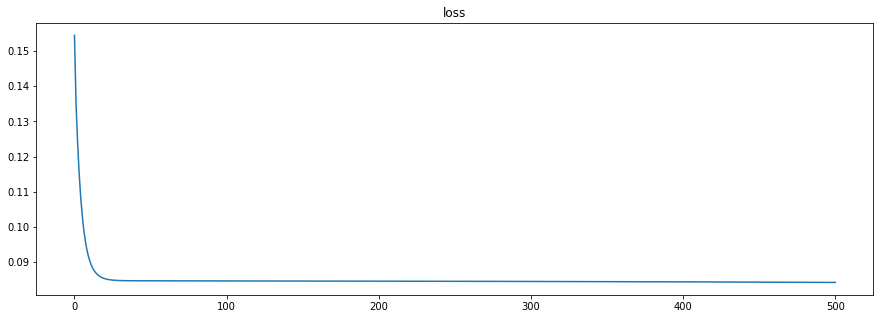

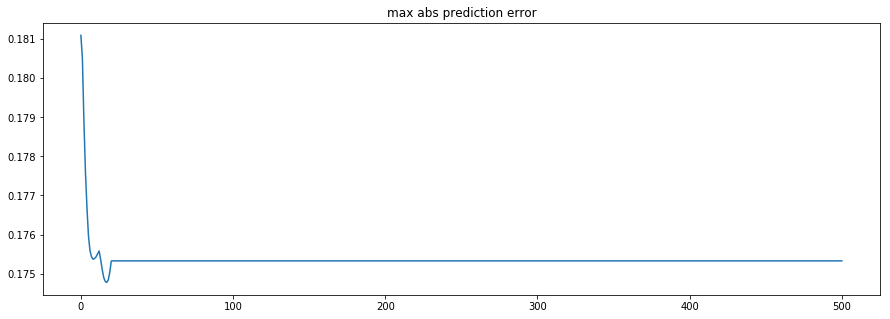

In [26]:
import cProfile, pstats, io
profile = False

if profile:
    pr = cProfile.Profile()
    pr.enable()
network = None
network = experiment(pattern, t_sample, epochs=501, network=network)

if profile:
    pr.disable()
    s = io.StringIO()
    sortby = 'cumulative'
    ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
    ps.print_stats()
    print(s.getvalue())